In [1]:
# Standard batch import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
import time
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
df=pd.read_csv('Hotel_Reviews.csv')


In [2]:
# Lets look at some stats shall we?
print(df.shape)
print(df.describe())
print(df.describe(include=['O']))
df.keys()


(515738, 17)
       Additional_Number_of_Scoring  Average_Score  \
count                 515738.000000  515738.000000   
mean                     498.081836       8.397487   
std                      500.538467       0.548048   
min                        1.000000       5.200000   
25%                      169.000000       8.100000   
50%                      341.000000       8.400000   
75%                      660.000000       8.800000   
max                     2682.000000       9.800000   

       Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
count                      515738.000000            515738.000000   
mean                           18.539450              2743.743944   
std                            29.690831              2317.464868   
min                             0.000000                43.000000   
25%                             2.000000              1161.000000   
50%                             9.000000              2134.000000   
75%              

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [3]:
# Just for fun, create a database with only hotels info
hotels=df[['Hotel_Name','Average_Score','Total_Number_of_Reviews',\
           'Hotel_Address', 'Additional_Number_of_Scoring','lat', 'lng']].drop_duplicates().reset_index()
print(hotels.shape)
hotels.head(3)


(1494, 8)


,index,Hotel_Name,Average_Score,Total_Number_of_Reviews,Hotel_Address,Additional_Number_of_Scoring,lat,lng
0,0,Hotel Arena,7.7,1403,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,52.360576,4.915968
1,405,K K Hotel George,8.5,1831,1 15 Templeton Place Earl s Court Kensington a...,244,51.491888,-0.194971
2,971,Apex Temple Court Hotel,9.2,2619,1 2 Serjeant s Inn Fleet Street City of London...,639,51.513734,-0.108751


In [4]:
# Now lets get some new columns running
# Hotel address ---> Country ('Netherlands', 'UK', 'France', 'Spain', 'Italy', 'Austria')
hotels['Country']=hotels['Hotel_Address'].apply(lambda x: x.split()[-1]).replace('Kingdom','UK')
hotels.Country.unique()


array(['Netherlands', 'UK', 'France', 'Spain', 'Italy', 'Austria'],
      dtype=object)

In [5]:
# I would be curious to see which country gives more reviews (UK most of the time)
# So lets get the most common nationality of reviews for each hotel
most_national=df[['Hotel_Name','Hotel_Address','Reviewer_Nationality']].groupby(['Hotel_Name','Hotel_Address']).agg(lambda x:x.value_counts().index[0])


In [6]:
# In case we want to use the Tags, here I clean up the format 
# and create list from Tags ranked them by occurence
tags_rank=pd.Series(re.findall(r'[\']\s([\w\s]+)\s[\']',''.join(df.Tags))).value_counts()


In [7]:
# For some reason days where not numbers but string so..
# Correct day of the review into integer
df['days_since_review']=pd.to_numeric(df['days_since_review'].str.replace(r'[a-z]+', ""))


In [8]:
# Lets isolate the reviews that have some information into negative/positive
# For simplicity I start getting the badly scored and highly scored reviews 
# to feed later on to the classifier.
# This was he/she/it will understand how a bad or good review looks like
# DataFrames with Negative reviews and positive reviews given
neg_rev=df[df.Negative_Review!='No Negative'].reset_index().drop('index',1)


In [9]:
pos_rev=df[df.Positive_Review!='No Positive'].reset_index().drop('index',1)


In [10]:
neg_rev = neg_rev[neg_rev['Reviewer_Score']<5].reset_index().drop('index',1)


In [11]:
pos_rev = pos_rev[pos_rev['Reviewer_Score']>8].reset_index().drop('index',1)


In [12]:
print(neg_rev)

                                           Hotel_Address  \
0       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
5       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
6       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
7       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
8       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
9       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
10      s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
11      s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
12      s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
13      s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
14      s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
15      s Gravesandestraat 55 Oost 1092 

In [13]:
print(pos_rev)

                                            Hotel_Address  \
0        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
5        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
6        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
7        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
8        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
9        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
10       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
11       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
12       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
13       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
14       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
15       s Gravesandestr

In [14]:
# Takes review and gives back the clean list of words

#TokTok faster than word_tokenize
from nltk.tokenize import ToktokTokenizer
toktok = ToktokTokenizer()


In [15]:
# Stopwords, numbers and punctuation to remove
remove_punct_and_digits = dict([(ord(punct), ' ') for punct in string.punctuation + string.digits])
stopWords = set(stopwords.words('english'))


In [16]:
def word_cleaner(data):
    cleaned_word = data.lower().translate(remove_punct_and_digits)
    words = word_tokenize(cleaned_word)
    words = [toktok.tokenize(sent) for sent in sent_tokenize(cleaned_word)]
    wordsFiltered = []
    if not words:
        pass
    else:
        for w in words[0]:
            if w not in stopWords:
                wordsFiltered.append(w)
                end=time.time()
    return wordsFiltered




In [17]:
# Example
wordsFiltered = word_cleaner(neg_rev.Negative_Review[1])


In [18]:
print(neg_rev.Negative_Review[1])


 My room was dirty and I was afraid to walk barefoot on the floor which looked as if it was not cleaned in weeks White furniture which looked nice in pictures was dirty too and the door looked like it was attacked by an angry dog My shower drain was clogged and the staff did not respond to my request to clean it On a day with heavy rainfall a pretty common occurrence in Amsterdam the roof in my room was leaking luckily not on the bed you could also see signs of earlier water damage I also saw insects running on the floor Overall the second floor of the property looked dirty and badly kept On top of all of this a repairman who came to fix something in a room next door at midnight was very noisy as were many of the guests I understand the challenges of running a hotel in an old building but this negligence is inconsistent with prices demanded by the hotel On the last night after I complained about water damage the night shift manager offered to move me to a different room but that offer 

In [19]:
print(wordsFiltered)

['room', 'dirty', 'afraid', 'walk', 'barefoot', 'floor', 'looked', 'cleaned', 'weeks', 'white', 'furniture', 'looked', 'nice', 'pictures', 'dirty', 'door', 'looked', 'like', 'attacked', 'angry', 'dog', 'shower', 'drain', 'clogged', 'staff', 'respond', 'request', 'clean', 'day', 'heavy', 'rainfall', 'pretty', 'common', 'occurrence', 'amsterdam', 'roof', 'room', 'leaking', 'luckily', 'bed', 'could', 'also', 'see', 'signs', 'earlier', 'water', 'damage', 'also', 'saw', 'insects', 'running', 'floor', 'overall', 'second', 'floor', 'property', 'looked', 'dirty', 'badly', 'kept', 'top', 'repairman', 'came', 'fix', 'something', 'room', 'next', 'door', 'midnight', 'noisy', 'many', 'guests', 'understand', 'challenges', 'running', 'hotel', 'old', 'building', 'negligence', 'inconsistent', 'prices', 'demanded', 'hotel', 'last', 'night', 'complained', 'water', 'damage', 'night', 'shift', 'manager', 'offered', 'move', 'different', 'room', 'offer', 'came', 'pretty', 'late', 'around', 'midnight', 'alrea

In [20]:
# We take a small sample within our database to speed up Learning
# with a decent machine and some time to spare we can easily skip this step
neg_red=neg_rev[:50000].copy()


In [21]:
pos_red=pos_rev[:50000].copy()

In [22]:
# Create set related to positive and negative review
def word_feats(words):
    return dict([(word, True) for word in words])


In [23]:
neg_set=[(word_feats(word_feats(word_cleaner(neg_red.loc[i,'Negative_Review']))), 0) for i in range(len(neg_red))]


In [24]:
pos_set=[(word_feats(word_feats(word_cleaner(pos_red.loc[i,'Positive_Review']))), 1) for i in range(len(pos_red))]

In [25]:
# Finally some Machine is Learning!
# Train the model and use CV to test accuracy

negcutoff = int(len(neg_set)*3/4)
poscutoff = int(len(pos_set)*3/4)


In [27]:
print(negcutoff)

16224


In [29]:
print(poscutoff)

37500


In [30]:
trainfeats = neg_set[:negcutoff] + pos_set[:poscutoff]


In [31]:
testfeats = neg_set[negcutoff:] + pos_set[poscutoff:]


In [32]:
print(len(trainfeats), len(testfeats))

53724 17908


In [34]:
classifier = NaiveBayesClassifier.train(trainfeats)


In [35]:
print(classifier)

In [37]:
print( 'accuracy:', nltk.classify.util.accuracy(classifier, testfeats))

accuracy: 0.8930645521554612


In [38]:
# Now we want to have a clear overview of the most hated/loved words so...
# Builds the dataframe of words with respective sentiment and score

cpdist = classifier._feature_probdist


In [40]:
word=[]
score=[]
sentiment=[]


In [41]:
print(word)

[]


In [42]:
for (fname, fval) in classifier.most_informative_features(100):
            def labelprob(l):
                return cpdist[l, fname].prob(fval)

            labels = sorted([l for l in classifier._labels
                             if fval in cpdist[l, fname].samples()],
                            key=labelprob)
            if len(labels) == 1:
                continue
            l0 = labels[0]
            l1 = labels[-1]
            if cpdist[l0, fname].prob(fval) == 0:
                ratio = 'INF'
            else:
                ratio = '%8.1f' % (cpdist[l1, fname].prob(fval) /
                                   cpdist[l0, fname].prob(fval))
            sentiment.append(int(l1))
            word.append(fname)
            score.append(float(ratio))


In [43]:
# Divides scores into negative and positive
word_scores=pd.DataFrame({'word':word,'sentiment':sentiment,'score':score})


In [44]:
neg_word_scores=word_scores[word_scores.sentiment==0]


In [45]:
pos_word_scores=word_scores[word_scores.sentiment==1]


In [46]:
print(word_scores[word_scores['sentiment']==1].head())



           word  sentiment  score
7        superb          1  198.0
20    delicious          1  127.1
47    excellent          1   77.8
54          fab          1   72.0
56  beautifully          1   70.8


In [47]:
print(word_scores[word_scores['sentiment']==0].head())

         word  sentiment  score
0       worst          0  929.9
1        rude          0  691.1
2       dirty          0  648.6
3  disgusting          0  361.3
4    terrible          0  302.3


In [48]:
neg_given=df[df.Negative_Review!='No Negative'].reset_index().drop('index',1)


In [49]:
print(neg_given)

                                            Hotel_Address  \
0        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
5        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
6        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
7        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
8        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
9        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
10       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
11       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
12       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
13       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
14       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
15       s Gravesandestr

In [50]:
pos_given=df[df.Positive_Review!='No Positive'].reset_index().drop('index',1)
print(pos_given)

                                            Hotel_Address  \
0        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
5        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
6        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
7        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
8        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
9        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
10       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
11       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
12       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
13       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
14       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
15       s Gravesandestr

In [53]:
# I want to create two new columns, one that will give a positive and one a negative score
# Sums positive and negative scores for a given review
def pos_sentiment_sum(review):
    pos=0
    asd=word_cleaner(review)
    set_w=set(pos_word_scores.word)-set(['no','negative','positive'])
    
    for word in asd:
        if word in set_w:
            pos+=pos_word_scores[pos_word_scores['word']==word].score.iloc[0]
    
    return pos


In [54]:
def neg_sentiment_sum(review):
    neg=0
    asd=word_cleaner(review)
    set_w=set(neg_word_scores.word)-set(['no','negative','positive'])
    
    for word in asd:
        if word in set_w:
            neg+=neg_word_scores[neg_word_scores['word']==word].score.iloc[0]
    
    return neg



In [55]:
# TEST
print('negative score:',neg_sentiment_sum(df.Negative_Review[6584]),\
       'positive score:', pos_sentiment_sum(df.Positive_Review[6584]))


negative score: 0 positive score: 77.8


In [56]:
# The analysis can go on, but this is the last step for now
# Reviews grouped by rate band
score_9=df[df.Reviewer_Score>9].copy()


In [57]:
print(score_9)

                                            Hotel_Address  \
7        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
10       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
13       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
15       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
23       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
24       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
26       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
29       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
30       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
43       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
48       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
50       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
52       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
53       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
55       s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
59       s Gravesandestr

In [58]:
score_4=df[df.Reviewer_Score<4].copy()
score_6=df[df.Reviewer_Score<7].copy()


In [59]:
score_7=df[(df.Reviewer_Score>7)&(df.Reviewer_Score<8)].copy()
score_8=df[(df.Reviewer_Score>8)&(df.Reviewer_Score<9)].copy()


In [60]:
print(score_6.shape)
print(score_7.shape)
print(score_8.shape)
print(score_9.shape)


(86851, 17)
(92830, 17)
(88104, 17)
(246390, 17)


In [61]:
# Some plots

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.style.use('fivethirtyeight')


In [62]:

plt.figure(figsize=(7,7))


<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

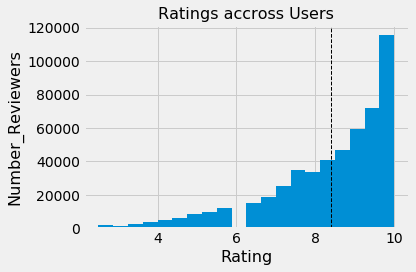

In [63]:
plt.hist(df['Reviewer_Score'],bins=20)
plt.ylabel('Number_Reviewers',fontsize=16)
plt.xlabel('Rating',fontsize=16)
plt.title('Ratings accross Users',fontsize=16)
plt.axvline(df['Reviewer_Score'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_user.png')


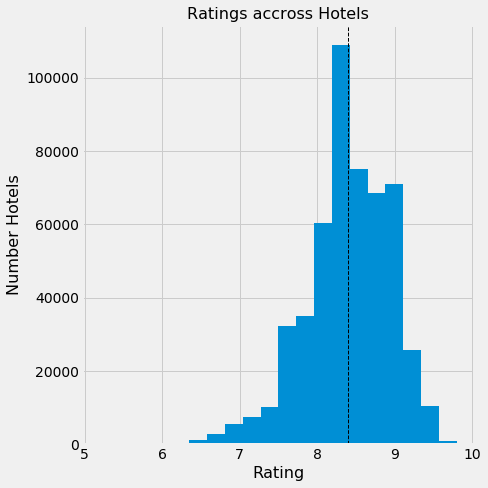

In [64]:
plt.figure(figsize=(7,7))
plt.hist(df['Average_Score'],bins=20)
plt.ylabel('Number Hotels',fontsize=16)
plt.xlabel('Rating',fontsize=16)
plt.title('Ratings accross Hotels',fontsize=16)
plt.axvline(df['Average_Score'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_hotel.png')



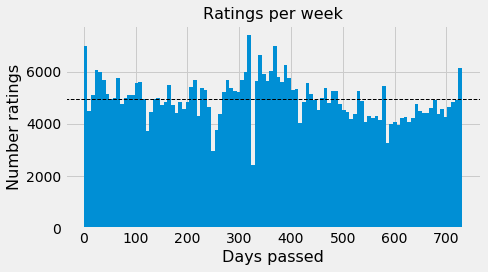

In [65]:
plt.figure(figsize=(7,4))
week_bins=int(np.floor((max(df['days_since_review'])-min(df['days_since_review']))/7))
vals = plt.hist(df['days_since_review'],bins=week_bins);
plt.ylabel('Number ratings',fontsize=16)
plt.xlabel('Days passed',fontsize=16)
plt.title('Ratings per week',fontsize=16)
plt.axhline(vals[0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_week.png')


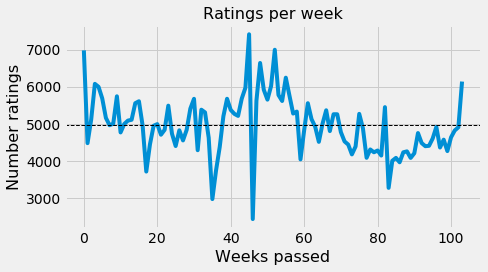

In [66]:
plt.figure(figsize=(7,4))
plt.plot(vals[0]);
plt.ylabel('Number ratings',fontsize=16)
plt.xlabel('Weeks passed',fontsize=16)
plt.title('Ratings per week',fontsize=16)
plt.axhline(vals[0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_week_plot.png')



In [67]:
print(review)

NameError: name 'review' is not defined